# Лабораторная работа 3

> =========================================
>
> Тема: Обработка текстов
>
> Набор данных: MTC AI - игры, влоги, обзоры техники, реакции
>
> Студент: Щацкий Никита ИУ7-21М
> 
>=========================================

## 0. Импорты

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy3
import math
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [4]:
#nltk.download("stopwords") # для первого запуска

## 1. Данные

### 1.1. Стопслова

In [5]:
stopWords = stopwords.words("russian")
stopWords.append("он")
stopWords.append("она")
stopWords.append("это")

morph = pymorphy3.MorphAnalyzer(lang='ru')

In [6]:
def delete_stop_words(text):
    return [word for word in text if word not in stopWords]

def format_data(text):
    fmtTextStr = re.sub(r'[^\w\s]', ' ', text.lower(), flags=re.UNICODE)
    tokenTextArr = nltk.word_tokenize(fmtTextStr)
    cleanTextArr = delete_stop_words(tokenTextArr)
    return " ".join(cleanTextArr)


In [7]:
def get_normalFormStr(line):
    return " ".join([morph.parse(word)[0].normal_form for word in line.split() if morph.parse(word)[0].normal_form not in stopWords])

### 1.2. Чтение

In [8]:
def read_files(filename, format):
    i = 1
    dataArr = []
    while True:
        try:
            fd = open(filename + str(i) + format, encoding="utf-8")
        except Exception:
            break
        
        dataArr.append([i, fd.read()])
        
        fd.close()
        i += 1
    return dataArr

In [9]:
gameArr = read_files("./data/1-game_", ".txt")
vlogArr = read_files("./data/2-vlog_", ".txt")
techArr = read_files("./data/3-tech_", ".txt")
reactArr = read_files("./data/4-react_", ".txt")

### 1.3. В DataFrame

In [10]:
gameDF = pd.DataFrame(gameArr, columns=['num_doc', 'text'])
gameDF["class"] = "game"

vlogDF = pd.DataFrame(vlogArr, columns=['num_doc', 'text'])
vlogDF["class"] = "vlog"

techDF = pd.DataFrame(techArr, columns=['num_doc', 'text'])
techDF["class"] = "tech"

reactDF = pd.DataFrame(reactArr, columns=['num_doc', 'text'])
reactDF["class"] = "react"

In [11]:
videosDF = pd.concat([gameDF, vlogDF, techDF, reactDF])
videosDF.head(10)

,num_doc,text,class
0,1,Этот ролик просто поражает своей графикой и ат...,game
1,2,Впечатляющее видео! Я был поражен деталями в б...,game
2,3,Эта игра точно обещает стать новым эталоном в ...,game
3,4,"Смотря на этот ролик, я просто не могу поверит...",game
4,5,"Меня порадовало то, как игра балансирует между...",game
5,6,Один из самых впечатляющих аспектов этого роли...,game
6,7,"Невероятно, как много деталей и внимания к мир...",game
7,8,"Мне очень нравится то, как разнообразны возмож...",game
8,9,Очень впечатляющий ролик! Не могу не отметить ...,game
9,10,Я просто ошеломлен масштабом и красотой этого ...,game


## 2. Выполнение

### 2.1. Кластеризация

In [12]:
videosDF["formated"] = videosDF.text.apply(lambda textFTale: get_normalFormStr(format_data(textFTale)))
videosDF["formated_withoutMorph"] = videosDF.text.apply(lambda textFTale: format_data(textFTale))

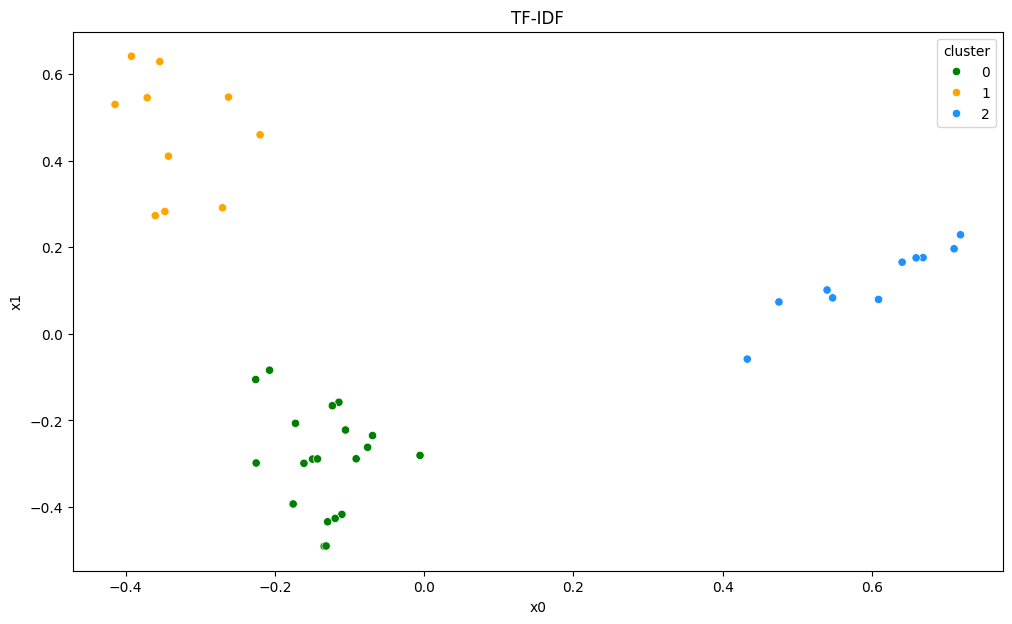

0.875
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00         4

    accuracy                           0.88        16
   macro avg       0.87      0.93      0.88        16
weighted avg       0.93      0.88      0.88        16



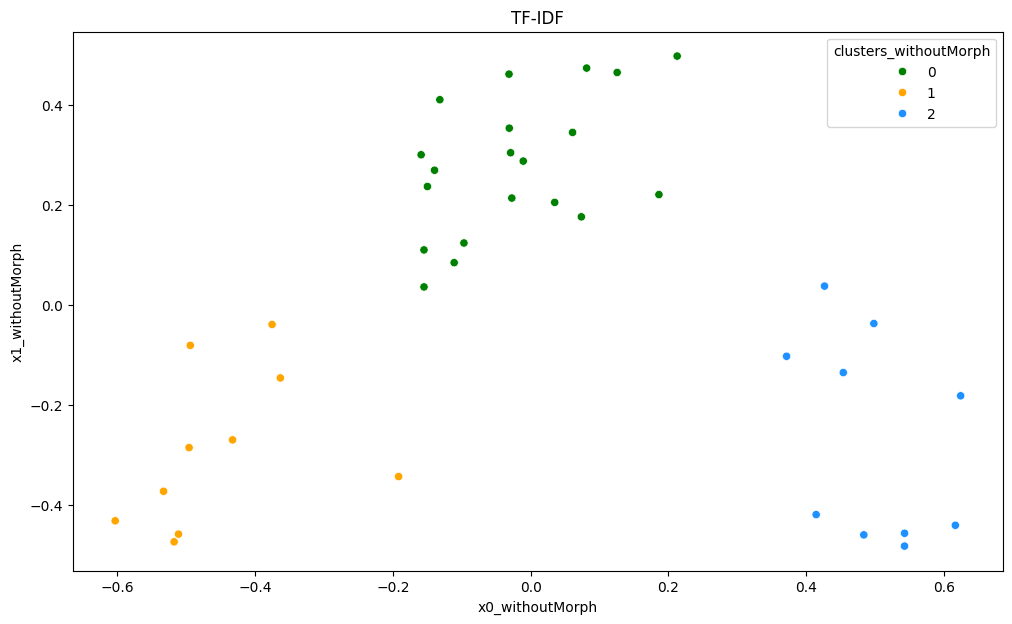

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [13]:
def _getVectorizer(fieldName):
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    x = vectorizer.fit_transform(videosDF[fieldName])
    return x

def _getClusters(x, fieldName):
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(x)
    clusters = kmeans.labels_
    videosDF[fieldName] = clusters

def _pca(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    videosDF[fieldX0] = x0
    videosDF[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(data=videosDF, x=fieldX0, y=fieldX1, hue=fieldCluster, palette=['green', 'orange', 'dodgerblue'])
    plt.show()

def _calcAccuracy(x, fieldCluster):
    XVectorDf = pd.DataFrame(x.toarray())
    xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf, videosDF[fieldCluster], test_size = 0.4, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processTfIdf(fieldData, fieldCluster, fieldX0, fieldX1):
    X = _getVectorizer(fieldData)
    _getClusters(X, fieldCluster)
    _pca(X, fieldX0, fieldX1, fieldCluster)
    _calcAccuracy(X, fieldCluster)
    


processTfIdf('formated', 'cluster', "x0", "x1")
processTfIdf('formated_withoutMorph', 'clusters_withoutMorph', "x0_withoutMorph", "x1_withoutMorph")


### 2.2. Word2Vec

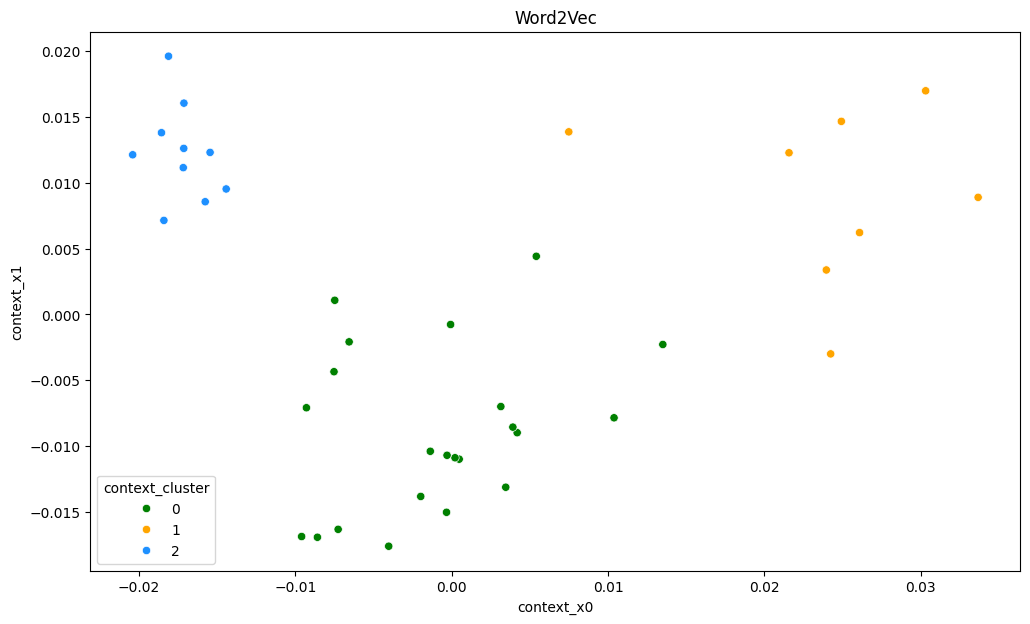

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



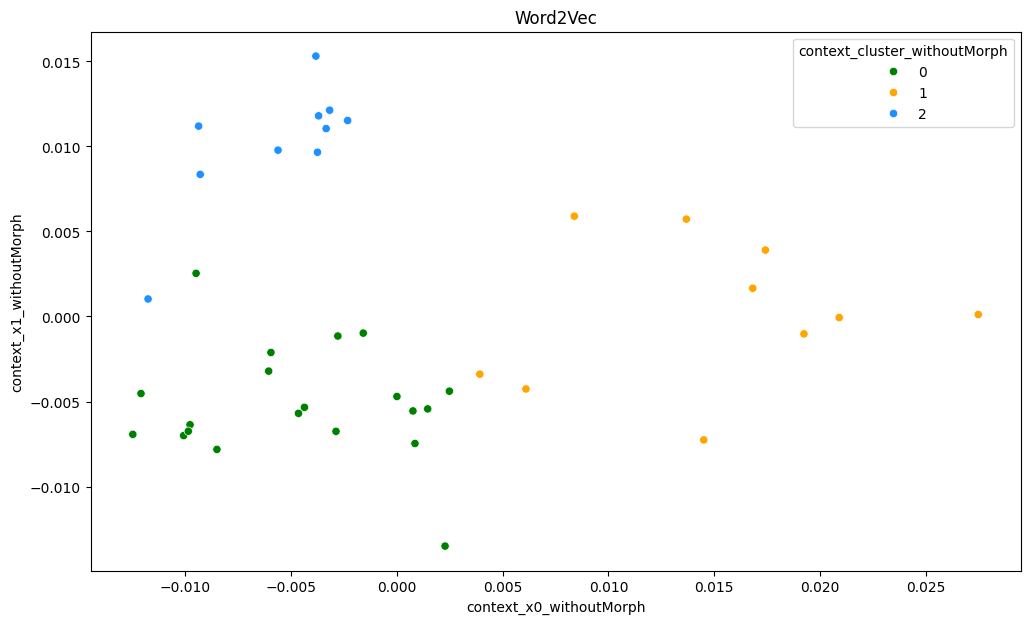

0.9375
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         4

    accuracy                           0.94        16
   macro avg       0.97      0.89      0.92        16
weighted avg       0.94      0.94      0.93        16



,num_doc,text,class,formated,formated_withoutMorph,cluster,x0,x1,clusters_withoutMorph,x0_withoutMorph,x1_withoutMorph,context_cluster,context_x0,context_x1,context_cluster_withoutMorph,context_x0_withoutMorph,context_x1_withoutMorph
0,1,Этот ролик просто поражает своей графикой и ат...,game,ролик просто поражать свой графика атмосфера к...,ролик просто поражает своей графикой атмосферо...,2,0.609043,0.079664,2,0.624192,-0.181402,2,-0.018566,0.013789,2,-0.005601,0.009779
1,2,Впечатляющее видео! Я был поражен деталями в б...,game,впечатляющий видео поразить деталь боевой сист...,впечатляющее видео поражен деталями боевой сис...,2,0.433069,-0.058227,2,0.498188,-0.037032,2,-0.018412,0.007133,2,-0.009276,0.008353
2,3,Эта игра точно обещает стать новым эталоном в ...,game,игра точно обещать стать новый эталон жанр rpg...,эта игра точно обещает стать новым эталоном жа...,2,0.710315,0.196696,2,0.414401,-0.418683,2,-0.014426,0.009519,2,-0.002314,0.011520
3,4,"Смотря на этот ролик, я просто не могу поверит...",game,смотреть ролик просто мочь поверить игра дело ...,смотря ролик просто могу поверить игра самом д...,2,0.547524,0.083307,2,0.426546,0.037677,2,-0.020408,0.012114,2,-0.011738,0.001029
4,5,"Меня порадовало то, как игра балансирует между...",game,порадовать игра балансировать сюжетный сцена и...,порадовало игра балансирует сюжетными сценами ...,2,0.668729,0.176214,2,0.616531,-0.440014,2,-0.017140,0.012598,2,-0.003163,0.012128
5,6,Один из самых впечатляющих аспектов этого роли...,game,самый впечатляющий аспект ролик атмосфера прос...,самых впечатляющих аспектов ролика атмосфера п...,2,0.640650,0.165714,2,0.542698,-0.481560,2,-0.015457,0.012294,2,-0.009350,0.011193
6,7,"Невероятно, как много деталей и внимания к мир...",game,невероятно деталь внимание мир игра каждый кад...,невероятно деталей внимания миру игры каждого ...,2,0.659415,0.175753,2,0.542765,-0.455971,2,-0.018116,0.019592,2,-0.003685,0.011797
7,8,"Мне очень нравится то, как разнообразны возмож...",game,очень нравиться разнообразный возможность перс...,очень нравится разнообразны возможности персон...,2,0.718896,0.229044,2,0.483602,-0.459152,2,-0.017172,0.011137,2,-0.003814,0.015309
8,9,Очень впечатляющий ролик! Не могу не отметить ...,game,очень впечатляющий ролик мочь отметить работа ...,очень впечатляющий ролик могу отметить работу ...,2,0.475540,0.073804,2,0.371455,-0.102470,2,-0.015768,0.008551,2,-0.003738,0.009654
9,10,Я просто ошеломлен масштабом и красотой этого ...,game,просто ошеломить масштаб красота мир ролик дей...,просто ошеломлен масштабом красотой мира ролик...,2,0.540044,0.101423,2,0.453805,-0.135003,2,-0.017130,0.016032,2,-0.003328,0.011047


In [14]:
def _get_w2vdf(fieldData):
    w2v_df = pd.DataFrame(videosDF[fieldData]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df

def _train_w2v(w2v_df):
    w2v_model = Word2Vec(min_count=1, vector_size=100)
    
    w2v_model.build_vocab(w2v_df)
    w2v_model.train(w2v_df, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
    return w2v_model

def _preprocess(s):
    return [i for i in s.split()]

def _get_vector(s, model):
    return np.sum(np.array([model.wv[i] for i in _preprocess(s)]), axis=0)

def _pcaContext(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]


    videosDF[fieldX0] = x0
    videosDF[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("Word2Vec")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(data=videosDF, x=fieldX0, y=fieldX1, hue=fieldCluster, palette=['green', 'orange', 'dodgerblue'])
    plt.show()

def _calcAccuracyContext(x, fieldCluster):
    XVectorDf = pd.DataFrame(x)
    xTraining, xTest, yTraining, yTest = train_test_split(XVectorDf, videosDF[fieldCluster], test_size = 0.4, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processContex(fieldData, fieldCluster, fieldX0, fieldX1):
    w2v_df = _get_w2vdf(fieldData)
    w2v_model = _train_w2v(w2v_df)

    x = [_get_vector(text, w2v_model) for text in videosDF[fieldData]]
    x = normalize(x)

    _getClusters(x, fieldCluster)
    _pcaContext(x, fieldX0, fieldX1, fieldCluster)
    _calcAccuracyContext(x, fieldCluster)

processContex("formated", "context_cluster", "context_x0", "context_x1")
processContex("formated_withoutMorph", "context_cluster_withoutMorph", "context_x0_withoutMorph", "context_x1_withoutMorph")

videosDF